In [1]:
train_image_folder = 'C:/USers/zecharpy/Desktop/YOLO2_keras/tiny_train_img/'
train_annot_folder = 'C:/USers/zecharpy/Desktop/YOLO2_keras/tiny_train_annot/'
valid_image_folder = 'C:/USers/zecharpy/Desktop/YOLO2_keras/tiny_val_img/'
valid_annot_folder = 'C:/USers/zecharpy/Desktop/YOLO2_keras/tiny_val_annot/'

In [2]:
from __future__ import absolute_import, division, print_function
import numpy as np
import argparse
import random
import os
from scipy import misc
from skimage import draw
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

def create_model(image_height, image_width, loss, optimizer):
    """Creates the cat face locator model.
    Args:
        image_height: The height of the input images.
        image_width: The width of the input images.
        loss: Keras loss function (name or object), e.g. "mse".
        optimizer: Keras optimizer to use, e.g. Adam() or "sgd".
    Returns:
        Sequential
    """

    model = Sequential()

    # 3x128x128
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(image_height, image_width,3)))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 64x64x64
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x32x32
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x16x16
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 256x8x8 = 16384
    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.5))

    model.add(Dense(4))
    model.add(Activation("linear"))

    # compile with mean squared error
    print("Compiling...")
    model.compile(loss=loss, optimizer=optimizer)

    return model

Using TensorFlow backend.


## parse annotation and create dataset and bounding boxes

In [3]:
import os
import cv2
import copy
import numpy as np

import xml.etree.ElementTree as ET


def parse_annotation_v2(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) >= 1 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

train_imgs, train_labels = parse_annotation_v2(train_annot_folder,
                                                train_image_folder,
                                                'microsoft')

val_imgs, val_labels = parse_annotation_v2(valid_annot_folder,
                                            valid_image_folder,
                                                'microsoft')


In [4]:
# construct an elliptical mask representing the center of the
# image
def overlap_area(a, b):  # returns None if rectangles don't intersect
    dx = min(a[2], b[2]) - max(a[0], b[0])
    dy = min(a[3], b[3]) - max(a[1], b[1])
    intercept_xmax=min(a[2],b[2])
    intercept_xmin=max(a[0],b[0])
    intercept_ymax=min(a[3],b[3])
    intercept_ymin=max(a[1],b[1])
    #print("dx",dx,"dy",dy)
    if (dx>=0) and (dy>=0):
        return dx*dy , dx, dy ,intercept_xmin,intercept_ymin, intercept_xmax, intercept_ymax
    else: 
        return 'no_overlap'
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou, inter_area


import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(40,40))


def NMS_debug(ith, train_imgs, show=False, cnt=0):
    y_class=[]
    y_coor=[]
    cnt=0

    #print(y_true.shape)
    image=cv2.imread(train_imgs[ith]['filename'])

    for obj in train_imgs[ith]['object']:
        #print(ith,obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
        b=(obj['xmin'],obj['ymin'],obj['xmax'],obj['ymax'])
        cv2.rectangle(image,(b[0],b[1]),(b[2],b[3]),(0,0,255),4)
        xmin_norm=b[0]/192.
        ymin_norm=b[1]/192.
        box_width=(b[2]-b[0])/192.
        box_height=(b[3]-b[1])/192.
        y_coor.append(np.array([xmin_norm,ymin_norm,box_width, box_height]))
        #print(np.array([xmin_norm,ymin_norm,box_width, box_height]).shape)
        """
        #print("bounding box ",b)
        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            a=(startX,startY, endX, endY )

            area_pts=overlap_area(a,b)
            prct,inter=iou(a,b)

            #cv2.rectangle(image, (startX, startY), (endX, endY), (0,255,0), 3)
            if type(area_pts) is not str and (area_pts[0]/1024)>0.:
                #print("segments",int(startX/32),int(startY/32))
                print("segment",int(startX),int(startY))
                print("area_points",prct,inter, area_pts[0]/1024,area_pts[3],area_pts[4],area_pts[5],area_pts[6])
                
                #print(area_pts)
                #cv2.rectangle(image, (area_pts[3], area_pts[4]), (area_pts[5], area_pts[6]), (0,255,0), 3)
                #print("area prct ", str(area_pts[0]), startX, endX, startY, endY)
                #print("check cloese centroids",startX/32., startY/32.,endX/32.,endY/32.)
                
                #print(((area_pts[5]-area_pts[3])/(2*32.)) ,((area_pts[6]-area_pts[4])/(2*32.)))                 
                y_class.append(1)
                
            else:
                y_class.append(0)
            """
                
                
    if show:
        plt.figure(figsize=(30,30))
        plt.imshow(image[:,:,[2,1,0]])
        plt.show()
    return  y_coor




<Figure size 2880x2880 with 0 Axes>

## create training and testing dataset

In [5]:
Y=[]
X=[]
X_test=[]
y_test=[]
cnt=0
for i in range(len(train_imgs)):
    im=cv2.imread(train_imgs[i]['filename'])
    im=im/255
    #print(im.shape)
    X.append(im)
    
    y_coor=NMS_debug(i, train_imgs, False,cnt=cnt)
    Y.append(y_coor)

Y=np.stack(Y, axis=0)
X=np.array(X)

for i in range(len(val_imgs)):
    im=cv2.imread(val_imgs[i]['filename'])
    im=im/255
    #print(im.shape)
    X_test.append(im)
    
    y_coor=NMS_debug(i, val_imgs, False,cnt=cnt)
    y_test.append(y_coor)

y_test=np.stack(y_test, axis=0)
X_test=np.array(X_test)
#reshape labels
Y=Y.reshape(95,4)
y_test=y_test.reshape(10,4)

Y.shape, X.shape, X_test.shape, y_test.shape


((95, 4), (95, 192, 192, 3), (10, 192, 192, 3), (10, 4))

## create model and then train the model 

In [6]:
m= create_model(192, 192, "mse", Adam())
m.load_weights('bbox_regressor_2.h5')

Compiling...


## train the model , save the best weights

In [79]:
checkpoint_cb = ModelCheckpoint('bbox_regressor_2.h5', verbose=1, \
                                    save_best_only=True)

m.fit(X,Y, batch_size=12, epochs=100, validation_data=(X_test, y_test),
          callbacks=[checkpoint_cb])


Train on 95 samples, validate on 10 samples
Epoch 1/100
95/95 [==============================] - 13s 137ms/step - loss: 0.0114 - val_loss: 0.0072

Epoch 00001: val_loss improved from inf to 0.00716, saving model to bbox_regressor_2.h5
Epoch 2/100
95/95 [==============================] - 12s 129ms/step - loss: 0.0108 - val_loss: 0.0190

Epoch 00002: val_loss did not improve
Epoch 3/100
95/95 [==============================] - 12s 132ms/step - loss: 0.0118 - val_loss: 0.0140

Epoch 00003: val_loss did not improve
Epoch 4/100
95/95 [==============================] - 19s 199ms/step - loss: 0.0109 - val_loss: 0.0397

Epoch 00004: val_loss did not improve
Epoch 5/100
95/95 [==============================] - 17s 179ms/step - loss: 0.0098 - val_loss: 0.0108

Epoch 00005: val_loss did not improve
Epoch 6/100
95/95 [==============================] - 15s 153ms/step - loss: 0.0113 - val_loss: 0.0047

Epoch 00006: val_loss improved from 0.00716 to 0.00465, saving model to bbox_regressor_2.h5
Epoch 

95/95 [==============================] - 14s 147ms/step - loss: 0.0068 - val_loss: 0.0060

Epoch 00057: val_loss did not improve
Epoch 58/100
95/95 [==============================] - 14s 144ms/step - loss: 0.0051 - val_loss: 0.0013

Epoch 00058: val_loss did not improve
Epoch 59/100
95/95 [==============================] - 14s 143ms/step - loss: 0.0058 - val_loss: 0.0027

Epoch 00059: val_loss did not improve
Epoch 60/100
95/95 [==============================] - 13s 141ms/step - loss: 0.0058 - val_loss: 0.0038

Epoch 00060: val_loss did not improve
Epoch 61/100
95/95 [==============================] - 14s 145ms/step - loss: 0.0058 - val_loss: 0.0080

Epoch 00061: val_loss did not improve
Epoch 62/100
95/95 [==============================] - 14s 148ms/step - loss: 0.0053 - val_loss: 9.7104e-04

Epoch 00062: val_loss improved from 0.00119 to 0.00097, saving model to bbox_regressor_2.h5
Epoch 63/100
95/95 [==============================] - 16s 170ms/step - loss: 0.0051 - val_loss: 0.0032


## save the entire model and weights

In [7]:
# m.save('final_microsoftlogo.h5')
from keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('final_microsoftlogo.h5')

## plot results

0026.jpeg
pred [0.17837168 0.26315907 0.13126244 0.20952933]
true [0.1875     0.50520833 0.13020833 0.3125    ]
true 29 44 40 78
pred 34 50 25 40


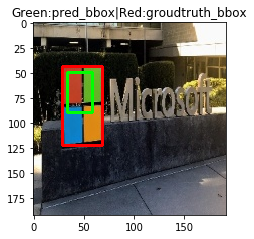

0071.jpg
pred [0.12068428 0.21456704 0.20443803 0.40974903]
true [0.17708333 0.17708333 0.16145833 0.31770833]
true 4 29 58 95
pred 23 41 39 78


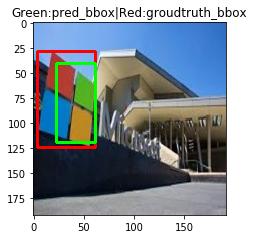

0085.jpg
pred [0.13560838 0.3754118  0.16749477 0.32879806]
true [0.02083333 0.28645833 0.203125   0.359375  ]
true 27 71 45 73
pred 26 72 32 63


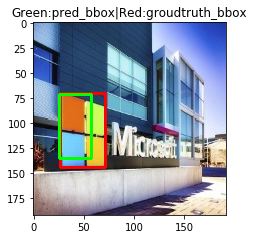

0026.jpeg
pred [0.17837168 0.26315907 0.13126244 0.20952933]
true [0.1875     0.50520833 0.13020833 0.3125    ]
true 29 44 40 78
pred 34 50 25 40


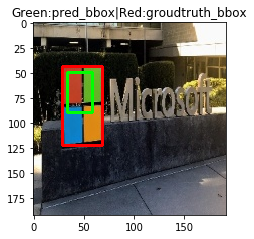

0003.jpg
pred [0.14411226 0.49446744 0.16352978 0.29975712]
true [0.40625  0.34375  0.0625   0.140625]
true 36 97 25 60
pred 27 94 31 57


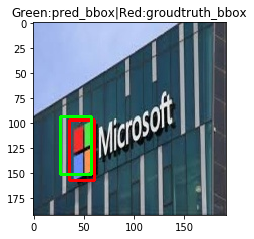

In [10]:
%matplotlib inline
import random
val_ls=os.listdir(valid_image_folder)
max_image_displayed=5
for i in range(max_image_displayed):
    plt.figure(figsize=(20,20))
    plt.subplot(1,max_image_displayed,i+1)
    rn=random.randint(0,len(val_ls)-1)
    print(val_ls[rn])
    im=cv2.imread(valid_image_folder+val_ls[rn])
    ye = model.predict(im.reshape(1,192,192,3))
    x,y,w,h=[int(k) for k in ye[0]*192]
    print("pred",ye[0])
    tx,ty,tw,th=[int(k) for k in y_test[rn]*192]
    print("true",Y[rn])
    print("true",tx,ty,tw,th)
    print("pred",x,y,w,h)
    cv2.rectangle(im, (tx,ty),(tx+tw,ty+th), (0,0,255),2)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(im[:,:,[2,1,0]])
    plt.title("Green:pred_bbox|Red:groudtruth_bbox")
    plt.show()
